# data preproccessing


## import modules and configure notebook

In [1]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from preproccessing import clean_columns, split_data, replace_outliers 

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)
%matplotlib inline

/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
from config import * 

### Import data

In [3]:
my_data = pd.read_csv(data_input_path)

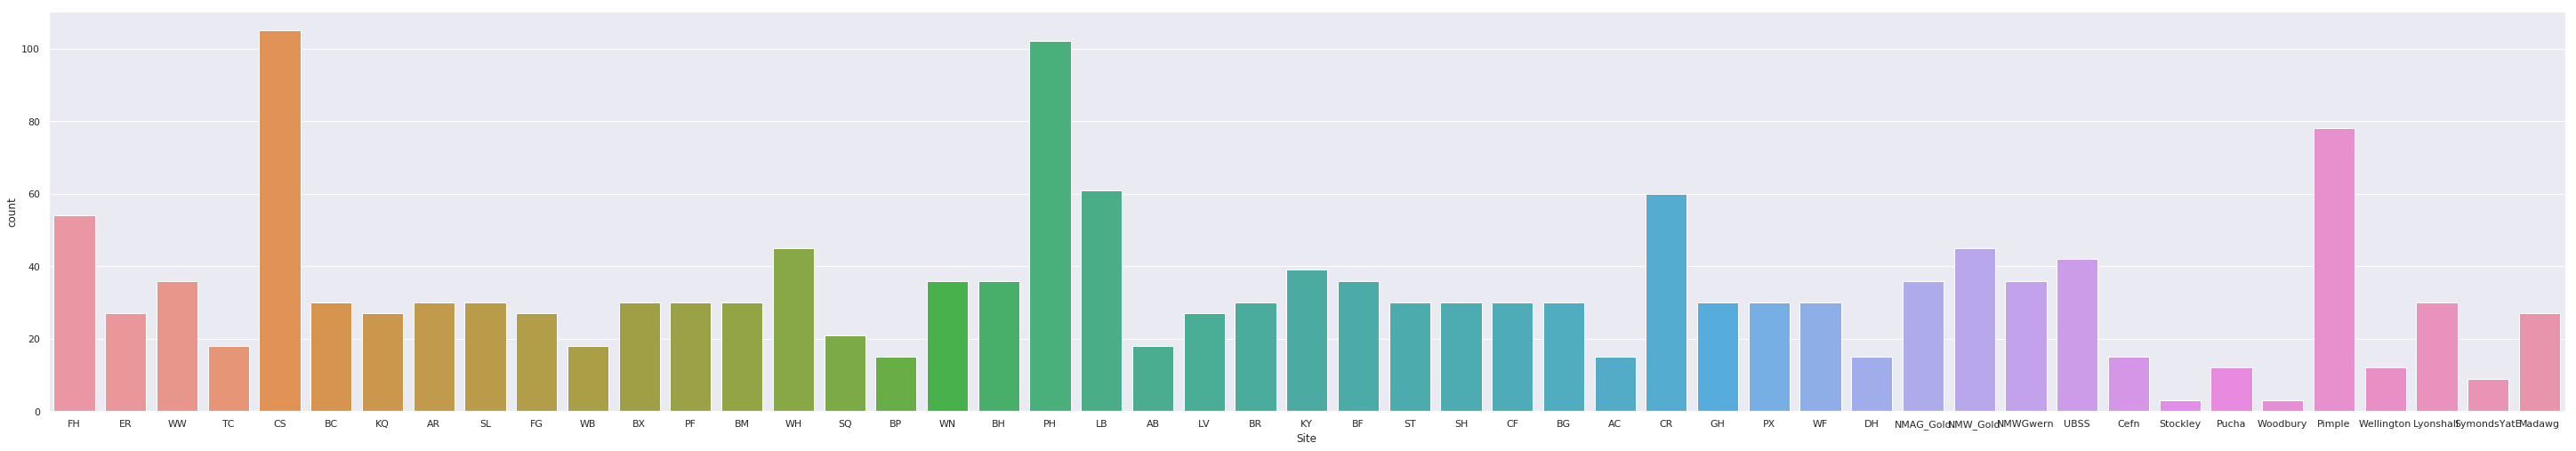

In [4]:
sns.set(rc={'figure.figsize':(50.7,8.27)})
sns.countplot(my_data['Site'])

### features

In [5]:
my_data.columns.values[features_start:features_end]

array(['Li7', 'Be9', 'B11', 'Mg24', 'Al27', 'Si28', 'P31', 'S33', 'K39',
       'Ca42', 'Sc45', 'Ti47', 'V51', 'Cr52', 'Mn55', 'Fe56', 'Co59',
       'Ni60', 'Cu63', 'Zn68', 'Ga69', 'Ge72', 'As75', 'Rb85', 'Sr88',
       'Y89', 'Zr90', 'Nb93', 'Mo95', 'Cd111', 'In115', 'Sn118', 'Cs133',
       'Ba137', 'La139', 'Ce140', 'Pr141', 'Nd146', 'Sm147', 'Eu153',
       'Gd157', 'Tb159', 'Dy163', 'Ho165', 'Er166', 'Tm169', 'Yb172',
       'Lu175', 'Hf178', 'Ta181', 'Pb208', 'Th232'], dtype=object)

### remove bedrock site 'BP' because class-specific F1 score was very bad due to limited sample number 

In [9]:
my_data = my_data[my_data['Site']!='BP']

if bedrock_only:
    my_data = my_data[my_data['Geology'] != 'Superficial']

In [10]:
site_frequencies_df = pd.DataFrame(my_data.Site.value_counts()).reset_index(drop = False).rename(columns = {'Site':'Number of Observations', 'index':'Site'})
%store site_frequencies_df

Stored 'site_frequencies_df' (DataFrame)


### raw sample names including sample sites and artefacts

In [11]:
my_data['Site'].unique()

array(['FH', 'ER', 'WW', 'TC', 'CS', 'BC', 'KQ', 'AR', 'SL', 'FG', 'WB',
       'BX', 'PF', 'BM', 'WH', 'SQ', 'WN', 'BH', 'PH', 'LB', 'DH',
       'NMAG_Gold', 'NMW_Gold', 'NMWGwern', 'UBSS', 'Cefn', 'Stockley',
       'Pucha', 'Woodbury', 'Pimple', 'Wellington', 'Lyonshall',
       'SymondsYatE', 'Madawg', nan], dtype=object)

### define functions for making target classes for classification

In [12]:

def make_classes_grouped_reduced(row):
    if row['Geology'] == 'Bedrock':
        if row['Site'] == 'WB' or row['Site'] == 'BX':
            return('WB_BX')
        else:
            return(row['Site'])
    elif row['Geology'] == 'Superficial':
        if row['Region'] == 'SV' or row['Region'] == 'SE':
            return('SV_SE')
        else:
            return(row['Region'])

### targets for classification are made

In [13]:
my_data['class'] = my_data.apply(make_classes_grouped_reduced, axis = 1)

In [14]:
if drop_semi_bedrock:
    my_data = my_data[(my_data['class'] != 'BM') & (my_data['class'] != 'BC') & (my_data['class'] != 'BP') ]

### remove '<' signs and commas from feature values

In [15]:
my_data = clean_columns(my_data, 9, -1)    

Li7



Be9



B11



Mg24



Al27



Si28



P31



S33



K39



Ca42



Sc45



Ti47



V51



Cr52



Mn55



Fe56



Co59



Ni60



Cu63



Zn68



Ga69



Ge72



As75



Rb85



Sr88



Y89



Zr90



Nb93



Mo95



Cd111



In115



Sn118



Cs133



Ba137



La139



Ce140



Pr141



Nd146



Sm147



Eu153



Gd157



Tb159



Dy163



Ho165



Er166



Tm169



Yb172



Lu175



Hf178



Ta181



Pb208



Th232



U238


### visualise na values

sns.set(rc={'figure.figsize':(20.7,50)})
sns.heatmap(my_data.isna(), cbar=False)

### remove rows where there are all element abundances are na values 

In [16]:
my_data = my_data.dropna(subset=my_data.columns.values[9:-1], how = 'all' , axis = 0)

### split data into 'train_data' and 'test_data', the former consists of samples from known geological sites and the latter from flint artefacts fow which the original geological source site is unknown and to be predicted.

In [17]:
my_data_split_geological, my_data_split_artefacts = split_data(my_data, 'Geology','Artefacts')

### Impute na values with feature mean

In [18]:
for column_name in my_data_split_geological.columns.values[9:-1]:
    my_data_split_geological[column_name] = my_data_split_geological[column_name].fillna(my_data_split_geological[column_name].mean()) 

for column_name in my_data_split_artefacts.columns.values[9:-1]:
    my_data_split_artefacts[column_name] = my_data_split_artefacts[column_name].fillna(my_data_split_artefacts[column_name].mean())     

/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Outliers defined as any values that exceed 2 standard deviations from the mean, such values are changed to the mean for that variable

In [19]:
my_data_split_geological = replace_outliers(my_data_split_geological, features_start, features_end, num_stds = 2)
my_data_split_artefacts = replace_outliers(my_data_split_artefacts, features_start, features_end, num_stds = 2)

/Users/robbie.morse/developer/machine_learning/paper_1_notebooks/general_ML_functions.py:290: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data[col_name]= data.swifter.apply(impute_outliers_geo, axis = 1)


In [20]:
print(my_data_split_geological['Geology'].unique())
print(my_data_split_artefacts['Geology'].unique())

['Bedrock']
['Artefacts']


In [21]:
train_data = my_data_split_geological.copy(deep = True)
test_data = my_data_split_artefacts.copy(deep = True)


### label encode the class to be predicted

In [22]:
if bedrock_only:
    train_data_formodel = train_data[train_data['Geology'] == 'Bedrock'].copy(deep = True)
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])
else:
    train_data_formodel = train_data.copy(deep = True)
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])


### datasets are stored

In [23]:
%store train_data_formodel
%store train_data
%store test_data
%store my_data
%store uniques

Stored 'train_data_formodel' (DataFrame)
Stored 'train_data' (DataFrame)
Stored 'test_data' (DataFrame)
Stored 'my_data' (DataFrame)
Stored 'uniques' (Index)


## data preproccessing for dimensionality reduction and visualisation

### 'training_data' is split into two datasets, one consisting of samples from superficial sites and one containing samples from bedrock sites.

In [24]:
train_data_bedrock = train_data[train_data['Geology'] == 'Bedrock']
train_data_superficial = train_data[train_data['Geology'] == 'Superficial']

### four datasets are created, one containing all train data (bedrock and superficial types), one containing just bedrock types, one containing just superficial types and one containing the artefacts

In [25]:
element_data_train = train_data[train_data.columns.values[9:-1]]
element_data_train_bedrock = train_data_bedrock[train_data.columns.values[9:-1]]
element_data_train_superficial = train_data_superficial[train_data.columns.values[9:-1]]
element_data_test = test_data[test_data.columns.values[9:-1]]

### features are standardised

In [26]:
my_scaler_train = StandardScaler()
my_scaler_train_bedrock = StandardScaler()
my_scaler_train_superficial = StandardScaler()
my_scaler_test = StandardScaler()

In [28]:
element_data_train_scaled = my_scaler_train.fit_transform(element_data_train)
element_data_train_bedrock_scaled = my_scaler_train_bedrock.fit_transform(element_data_train_bedrock)
if bedrock_only == False:
    element_data_train_superficial_scaled = my_scaler_train_superficial.fit_transform(element_data_train_superficial)
element_data_test_scaled = my_scaler_test.fit_transform(element_data_test)

### T-Distributed Stochastic Neighbour Embedding is done on the four datasets

In [29]:
my_tsne_train = TSNE(n_components=2, n_iter=10000, verbose=3).fit_transform(element_data_train_scaled)
my_tsne_bedrock_train = TSNE(n_components=2, n_iter=10000, verbose=3).fit_transform(element_data_train_bedrock_scaled)
if bedrock_only == False:
    my_tsne_superficial_train = TSNE(n_components=2, n_iter=10000, verbose=3).fit_transform(element_data_train_superficial_scaled)
my_tsne_test = TSNE(n_components=2, n_iter=10000, verbose=3).fit_transform(element_data_test_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 786 samples in 0.001s...
[t-SNE] Computed neighbors for 786 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 786 / 786
[t-SNE] Mean sigma: 2.149524
[t-SNE] Computed conditional probabilities in 0.027s
[t-SNE] Iteration 50: error = 72.1232986, gradient norm = 0.3782451 (50 iterations in 0.568s)
[t-SNE] Iteration 100: error = 72.9464417, gradient norm = 0.3787342 (50 iterations in 0.325s)
[t-SNE] Iteration 150: error = 73.6368561, gradient norm = 0.3619340 (50 iterations in 0.319s)
[t-SNE] Iteration 200: error = 72.9256516, gradient norm = 0.3666552 (50 iterations in 0.339s)
[t-SNE] Iteration 250: error = 73.8278122, gradient norm = 0.3633957 (50 iterations in 0.320s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.827812
[t-SNE] Iteration 300: error = 1.4031069, gradient norm = 0.0029049 (50 iterations in 0.242s)
[t-SNE] Iteration 350: error = 1.2803112, gradient norm = 0.0021025 (

KeyboardInterrupt: 

### the t-SNE dimensions for the four datasets are put into dataframes

In [ ]:
tsne_df_train = pd.DataFrame(data = my_tsne_train, columns = ['tsne1', 'tsne2'])
tsne_df_bedrock_train = pd.DataFrame(data = my_tsne_bedrock_train, columns = ['tsne1', 'tsne2'])
if bedrock_only == False:
    tsne_df_superficial_train = pd.DataFrame(data = my_tsne_superficial_train, columns = ['tsne1', 'tsne2'])
tsne_df_test = pd.DataFrame(data = my_tsne_test, columns = ['tsne1', 'tsne2'])

### datasets are stored for the purpose of two-dimensional visualisations

In [ ]:
%store tsne_df_train

%store tsne_df_bedrock_train
%store tsne_df_superficial_train


%store tsne_df_test